## Exploratory Data Analysis

### Imports and definitions

In [399]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import albumentations
import albumentations.pytorch
import shap
import importlib
import preprocessing.crop_brain_region
import utils.load_images
import utils.metrics

#### Random seeds for reproducibility

In [400]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
sklearn.random.seed(0)

#### Set the device to run the models, GPU if it is available

In [401]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
cpu = torch.device("cpu")

#### Constants

In [402]:
IMAGE_SIZE = (224, 224)
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

#### Download the dataset

To run this, it's needed to have kaggle.json from a kaggle key in ~/.kaggle folder

Alternatively, skip this part and manually download the dataset https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection in ./data folder

In [403]:
import kaggle

os.makedirs("data", exist_ok=True)

kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    "volodymyrpivoshenko/brain-mri-scan-images-tumor-detection", path="data", unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection


### Loading images

In [404]:
images, labels = utils.load_images.load_images()

#### Visualizing images of each class

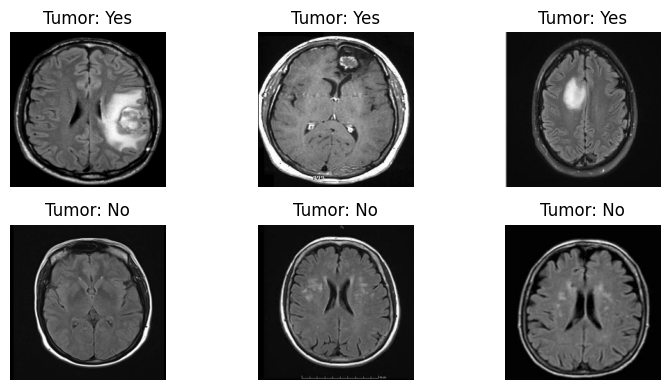

In [405]:
plt.figure(figsize=(8, 4))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[labels == 1][i + 10])
    plt.title("Tumor: Yes")
    plt.axis("off")

for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.imshow(images[labels == 0][i + 10])
    plt.title("Tumor: No")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Visualizing class distribution

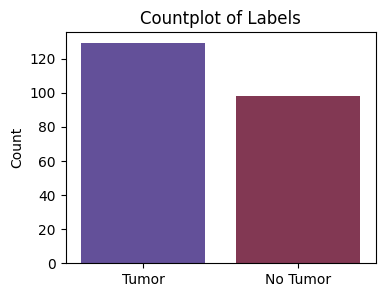

In [406]:
labels_nominal = np.where(labels == 0, "No Tumor", "Tumor")
plt.figure(figsize=(4, 3))
sns.countplot(x=labels_nominal, hue=labels_nominal, palette="twilight")
plt.title("Countplot of Labels")
plt.ylabel("Count")
plt.show()

### Data pre-processing

Using a custom transformation to crop the brain region, it is defined in [this python file](preprocessing/crop_brain_region.py) and it is possible to check its visual results in [this notebook](preprocessing/crop_brain_region_visualization.ipynb)

In [407]:
test_transform = albumentations.Compose(
    [
        preprocessing.crop_brain_region.CropBrainRegion(output_size=IMAGE_SIZE),
        albumentations.Normalize(),
        albumentations.pytorch.ToTensorV2(),
    ]
)

train_transform = albumentations.Compose(
    [
        preprocessing.crop_brain_region.CropBrainRegion(output_size=IMAGE_SIZE),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.5
        ),
        albumentations.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5
        ),
        albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        albumentations.GaussNoise(var_limit=(10, 50), p=0.5),
        albumentations.Normalize(mean=MEAN, std=STD),
        albumentations.pytorch.ToTensorV2(),
    ]
)

#### Data splitting

In [408]:
train_images, remaining_images, train_labels, remaining_labels = (
    sklearn.model_selection.train_test_split(
        images, labels, test_size=0.2, random_state=0
    )
)

val_images, test_images, val_labels, test_labels = (
    sklearn.model_selection.train_test_split(
        remaining_images, remaining_labels, test_size=0.5, random_state=0
    )
)

print("Train dataset size:", len(train_images))
print("Validation dataset size:", len(val_images))
print("Test dataset size:", len(test_images))

Train dataset size: 181
Validation dataset size: 23
Test dataset size: 23


#### Defining the dataset

In [409]:
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

In [410]:
train_dataset = BrainTumorDataset(train_images, train_labels, transform=train_transform)
val_dataset = BrainTumorDataset(val_images, val_labels, transform=test_transform)
test_dataset = BrainTumorDataset(test_images, test_labels, transform=test_transform)

batch_size = 8
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [411]:
loss = nn.BCELoss()

### Baseline CNN

Baseline CNN model, for exploratory data analysis

In [412]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 * 26 * 26, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)
model.to(device)
optim = torch.optim.Adam(model.parameters())

print("{:,}".format(sum(p.numel() for p in model.parameters())))

11,169,089


#### Training the baseline model

In [413]:
import utils.train_eval

importlib.reload(utils.train_eval)

num_epochs = 90

os.makedirs("checkpoints", exist_ok=True)

train_losses = []
val_losses = []
val_accs = []
best_val_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = utils.train_eval.train_epoch(model, train_loader, loss, optim, device)
    val_loss, val_acc, _ = utils.train_eval.eval_model(model, val_loader, loss, device)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join("checkpoints", "baseline_cnn.pth"))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if epoch % 3 == 2:
        print(
            f"Epoch {epoch + 1}/{num_epochs}. Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}"
        )

100%|██████████| 23/23 [00:09<00:00,  2.49it/s]


Epoch 3/90. Train Loss: 0.6525, Validation Loss: 0.6762, Validation Accuracy: 0.4783


100%|██████████| 23/23 [00:05<00:00,  4.01it/s]


Epoch 6/90. Train Loss: 0.6651, Validation Loss: 0.6544, Validation Accuracy: 0.3913


100%|██████████| 23/23 [00:04<00:00,  4.83it/s]


Epoch 9/90. Train Loss: 0.5783, Validation Loss: 0.6311, Validation Accuracy: 0.3913


100%|██████████| 23/23 [00:05<00:00,  3.85it/s]


Epoch 12/90. Train Loss: 0.6070, Validation Loss: 0.6184, Validation Accuracy: 0.7391


100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


Epoch 15/90. Train Loss: 0.5666, Validation Loss: 0.5508, Validation Accuracy: 0.7391


100%|██████████| 23/23 [00:07<00:00,  3.01it/s]


Epoch 18/90. Train Loss: 0.5244, Validation Loss: 0.6443, Validation Accuracy: 0.6522


100%|██████████| 23/23 [00:06<00:00,  3.62it/s]


Epoch 21/90. Train Loss: 0.5021, Validation Loss: 0.5230, Validation Accuracy: 0.6957


100%|██████████| 23/23 [00:07<00:00,  3.23it/s]


Epoch 24/90. Train Loss: 0.5218, Validation Loss: 0.5387, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:05<00:00,  4.16it/s]


Epoch 27/90. Train Loss: 0.5177, Validation Loss: 0.6464, Validation Accuracy: 0.7391


100%|██████████| 23/23 [00:06<00:00,  3.35it/s]


Epoch 30/90. Train Loss: 0.5172, Validation Loss: 0.5705, Validation Accuracy: 0.7391


100%|██████████| 23/23 [00:16<00:00,  1.36it/s]


Epoch 33/90. Train Loss: 0.5137, Validation Loss: 0.5729, Validation Accuracy: 0.6957


100%|██████████| 23/23 [00:05<00:00,  3.85it/s]


Epoch 36/90. Train Loss: 0.5686, Validation Loss: 0.5618, Validation Accuracy: 0.7391


100%|██████████| 23/23 [00:06<00:00,  3.56it/s]


Epoch 39/90. Train Loss: 0.4213, Validation Loss: 0.6291, Validation Accuracy: 0.7826


100%|██████████| 23/23 [00:05<00:00,  4.01it/s]


Epoch 42/90. Train Loss: 0.4676, Validation Loss: 0.5333, Validation Accuracy: 0.7826


100%|██████████| 23/23 [00:05<00:00,  4.03it/s]


Epoch 45/90. Train Loss: 0.4409, Validation Loss: 0.4454, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


Epoch 48/90. Train Loss: 0.4716, Validation Loss: 0.5315, Validation Accuracy: 0.7391


100%|██████████| 23/23 [00:05<00:00,  4.26it/s]


Epoch 51/90. Train Loss: 0.4045, Validation Loss: 0.6320, Validation Accuracy: 0.7391


100%|██████████| 23/23 [00:05<00:00,  4.03it/s]


Epoch 54/90. Train Loss: 0.4125, Validation Loss: 0.4025, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


Epoch 57/90. Train Loss: 0.3801, Validation Loss: 0.6834, Validation Accuracy: 0.7826


100%|██████████| 23/23 [00:05<00:00,  4.35it/s]


Epoch 60/90. Train Loss: 0.3829, Validation Loss: 0.4997, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:05<00:00,  4.10it/s]


Epoch 63/90. Train Loss: 0.4524, Validation Loss: 0.4868, Validation Accuracy: 0.7391


100%|██████████| 23/23 [00:05<00:00,  3.94it/s]


Epoch 66/90. Train Loss: 0.4022, Validation Loss: 0.5536, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:05<00:00,  4.29it/s]


Epoch 69/90. Train Loss: 0.3582, Validation Loss: 0.5048, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:05<00:00,  4.23it/s]


Epoch 72/90. Train Loss: 0.3981, Validation Loss: 0.3334, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


Epoch 75/90. Train Loss: 0.3447, Validation Loss: 0.4526, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:05<00:00,  4.02it/s]


Epoch 78/90. Train Loss: 0.3518, Validation Loss: 0.4731, Validation Accuracy: 0.9130


100%|██████████| 23/23 [00:05<00:00,  3.90it/s]


Epoch 81/90. Train Loss: 0.4009, Validation Loss: 0.4772, Validation Accuracy: 0.8261


100%|██████████| 23/23 [00:05<00:00,  4.01it/s]


Epoch 84/90. Train Loss: 0.3291, Validation Loss: 0.5496, Validation Accuracy: 0.7826


100%|██████████| 23/23 [00:05<00:00,  3.84it/s]


Epoch 87/90. Train Loss: 0.8662, Validation Loss: 0.4880, Validation Accuracy: 0.8696


100%|██████████| 23/23 [00:05<00:00,  4.18it/s]


Epoch 90/90. Train Loss: 0.3680, Validation Loss: 0.4922, Validation Accuracy: 0.7826


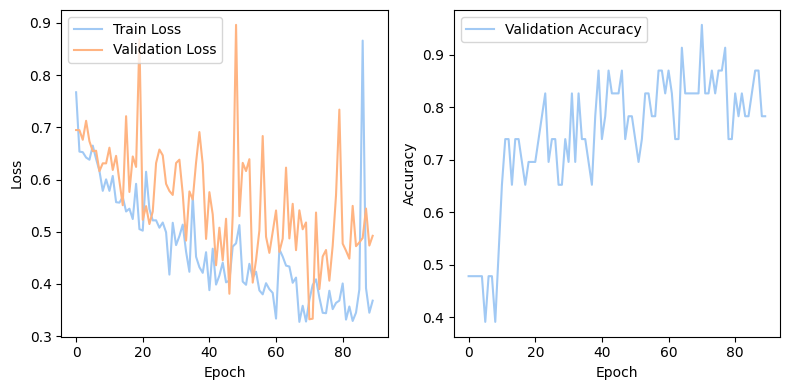

In [414]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [415]:
baseline_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 * 26 * 26, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)
baseline_cnn.load_state_dict(
    torch.load(os.path.join("checkpoints", "baseline_cnn.pth"))
)
baseline_cnn.to(device)
baseline_cnn.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=86528, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=1, bias=True)
  (13): Sigmoid()
)

#### Evaluating baseline CNN

           Validation      Test
Accuracy     0.956522  0.739130
Precision    1.000000  0.692308
Recall       0.909091  0.818182
F1-Score     0.952381  0.750000


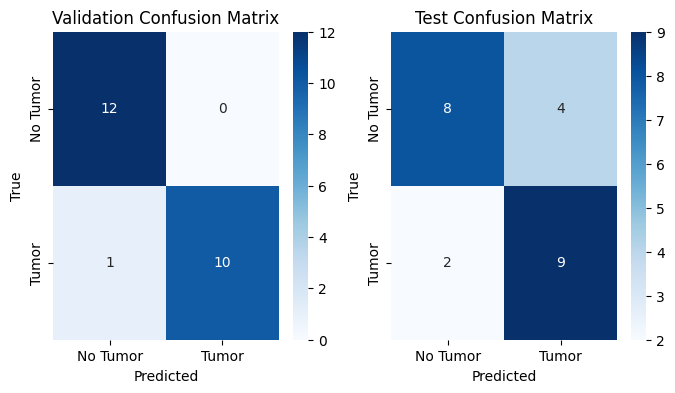

In [416]:
_, _, val_confusion_matrix = utils.train_eval.eval_model(
    baseline_cnn, val_loader, loss, device
)
_, _, test_confusion_matrix = utils.train_eval.eval_model(
    baseline_cnn, test_loader, loss, device
)

val_metrics = utils.metrics.get_metrics_from_confusion_matrix(val_confusion_matrix)
test_metrics = utils.metrics.get_metrics_from_confusion_matrix(test_confusion_matrix)

df = pd.DataFrame(
    {
        "Validation": [
            val_metrics["accuracy"],
            val_metrics["precision"],
            val_metrics["recall"],
            val_metrics["f1_score"],
        ],
        "Test": [
            test_metrics["accuracy"],
            test_metrics["precision"],
            test_metrics["recall"],
            test_metrics["f1_score"],
        ],
    },
    index=["Accuracy", "Precision", "Recall", "F1-Score"],
)
print(df)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.heatmap(
    val_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Tumor", "Tumor"],
    yticklabels=["No Tumor", "Tumor"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(
    test_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Tumor", "Tumor"],
    yticklabels=["No Tumor", "Tumor"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")

plt.show()

### Shapley Values

/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


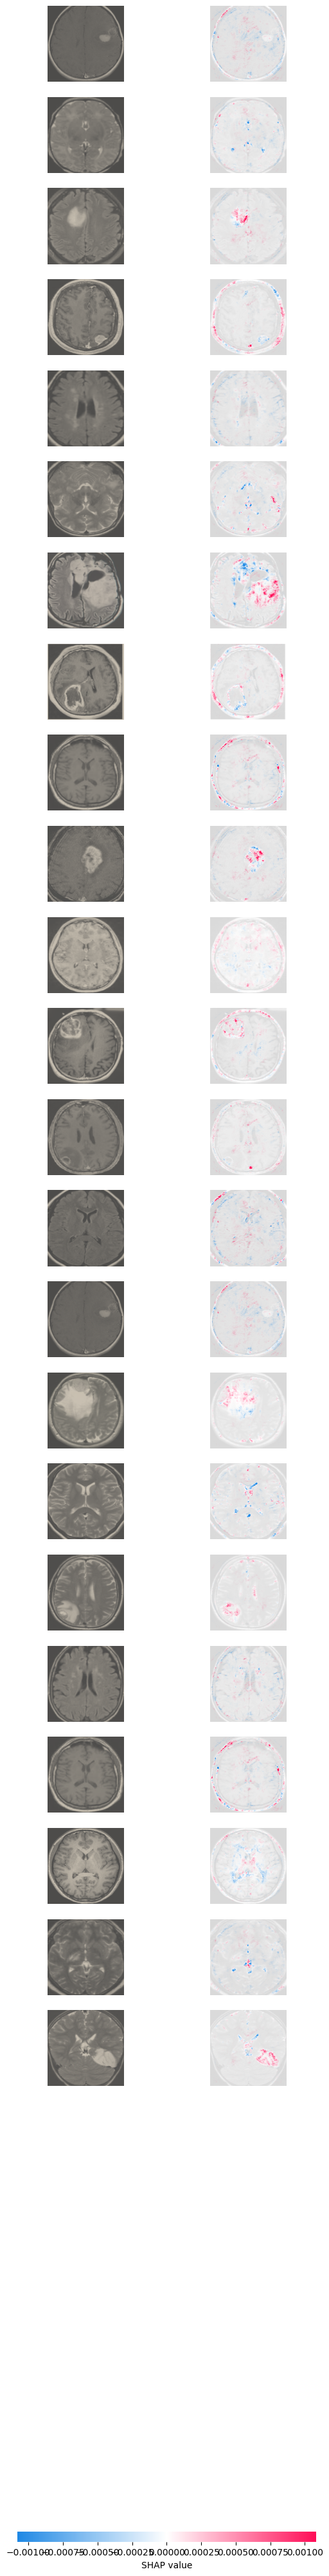

In [417]:
baseline_cnn.to("cpu")
baseline_cnn.eval()
test_loader_one_batch = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0
)

# Get a batch of data for SHAP explainer
inputs, targets = next(iter(test_loader_one_batch))
inputs, targets = inputs.to("cpu"), targets.to("cpu")

# Initialize SHAP DeepExplainer with the model and a sample of the test data
explainer = shap.DeepExplainer(baseline_cnn, inputs)

# Change from NCHW to NHWC
inputs_numpy = inputs.permute(0, 2, 3, 1).numpy()

inputs_numpy = inputs_numpy * MEAN + STD

# Compute SHAP values for the test data
shap_values = explainer.shap_values(inputs)

shap_values_numpy = np.array(shap_values)
shap_values_numpy = shap_values_numpy.squeeze().transpose(0, 2, 3, 1)

# Undo the standardization
mean = np.array(MEAN).reshape(1, 1, 1, 3)
std = np.array(STD).reshape(1, 1, 1, 3)
inputs_numpy = inputs_numpy * std + mean

# Plot the SHAP values for the first image
shap.image_plot(shap_values_numpy, inputs_numpy)